# 컨볼루션 인공신경망 Convolutional Neural Network
- MNIST 데이터
- 합성곱 연산(CNN)
- 맥스풀링(Max Pooling)
- 완전연결 신경망(Fully Connected Network)

In [1]:
# 파이토치 및 토치비젼 설치
# 런타임을 GPU 모드로 바꿔서 실행하세요
!pip install torch torchvision

### 1. 학습전 세팅

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/docs/stable/torchvision/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transforms
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.9.0+cu128


### 2. 하이퍼 파라미터 지정

In [3]:
batch_size = 256 # Gradient update 할 때 사용하는 샘플 수를 의미합니다.
learning_rate = 0.001 # 가중치를 얼마나 빠르게 업데이트할지 정하는 학습 속도를 의미합니다.
num_epoch = 10 # 전체 학습 데이터를 몇 번 반복해서 학습할지. 현재 값은 전체 데이터를 10번 반복해서 학습하는 것을 의미한다.

### 3.1 데이터 다운로드

In [5]:
# 첫번째 인자 root는 데이터를 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미합니다.

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있습니다.
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미합니다.
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줍니다.

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
mnist_train = dset.MNIST(root="./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.45MB/s]


### 3.2 데이터셋 체크
- getitem을 사용해도 좋습니다.
- 인덱싱으로도 데이터를 확인할 수 있습니다.

In [14]:
# MNIST 데이터는 28x28 크기의 흑백 이미지입니다. 따라서 1x28x28 크기의 텐서로 표현됩니다.
# 또한 학습용 데이터는 6만개, 테스트용 데이터는 1만개로 이루어져 있습니다.
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


### 3.3 DataLoader 설정
- 사용할 데이터
- 배치 사이즈 (batch_size)
- 섞을지 여부 (shuffle)
- 사용할 프로세스 개수 (num_workers)
- 마지막에 남는 데이터의 처리 여부 (drop_last)

In [25]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0,drop_last=True)

### 4.1 모델, 손실함수 최적화함수

In [ ]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), # Conv2d(1,16,5)적용 1x28x28 -> 16x28x28
            nn.ReLU(), # 활성화 함수로 ReLU를 사용합니다.
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # Conv2d(16,32,5)적용 16x28x28 -> 32x24x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 맥스풀링(2x2)적용: 32x24x24 -> 32x12x12
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), # Conv2d(32,64,5)적용 32x12x12 -> 64x8x8
            nn.ReLU(), # 활성화 함수로 ReLU를 사용합니다.
            nn.MaxPool2d(kernel_size=2, stride=2), # 맥스풀링(2x2)적용: 64x8x8 -> 64x4x4
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*4*4, 100), # Linear계층을 이용하여 64*4*4 차원의 텐서를 100차원으로 바꿔줍니다. (N, 1024) -> (N, 100)
            nn.ReLU(), # 활성화 함수로 ReLU를 사용합니다.
            nn.Linear(100, 10) # Linear계층을 이용하여 100차원 텐서를 10차원으로 변경합니다. 이유는 MNIST 데이터의 정답이 0부터 9까지 총 10개이기 때문입니다.
        )
    def forward(self, x):
        out = self.layer(x) # CNN 계층을 통과합니다. (N, 1, 28, 28) -> (N, 64, 4, 4)
        out = out.view(out.size(0), -1) # CNN 계층의 출력을 1차원 벡터로 바꿔줍니다. (N, 64, 4, 4) -> (N, 1024)
        out = self.fc_layer(out) # 완전 연결 계층을 통과합니다. (N, 1024) -> (N, 10)
        return out

In [28]:
# gpu 사용이 가능하면 gpu로 모델과 손실함수, 최적화 함수를 옮겨줍니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# 손실함수 정의 
loss_fn = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 5 학습

In [29]:
loss_arr =[] # 학습과정에서 손실함수 값이 어떻게 보기 위해 값을 저장하는 리스트입니다.
for i in range(num_epoch): # num_epoch만큼 전체 데이터를 반복해서 학습합니다.
    for j,[image,label] in enumerate(train_loader): # train_loader에서 배치 단위로 이미지와 라벨을 가져옵니다.
        x = image.to(device) 
        y_= label.to(device)

        optimizer.zero_grad() # 모델의 가중치 업데이트 전에 기울기를 초기화합니다. 그렇지 않으면 이전 배치에서 계산된 기울기가 누적됩니다.
        output = model.forward(x) # 모델에 입력 x를 넣어서 예측값 output을 계산합니다.
        loss = loss_fn(output,y_) # 모델의 예측값 output과 실제 정답 y_를 이용하여 손실함수 값을 계산합니다.
        loss.backward() # 손실함수 값을 모델의 가중치에 대한 기울기로 바꿔줍니다. 이 과정에서 역전파 알고리즘이 사용됩니다.
        optimizer.step() # 모델의 가중치를 기울기에 따라 업데이트합니다. 이 과정에서 최적화 알고리즘이 사용됩니다.

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward0>)


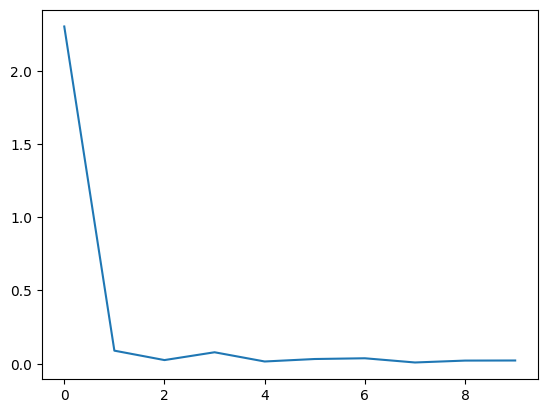

In [30]:
plt.plot(loss_arr)
plt.show()

In [31]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:

        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y_= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)

        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)

        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)

        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y_).sum().float()

    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 99.1786880493164%
